In [2]:
import pandas as pd
from catboost import Pool, CatBoostClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [64]:
train_data = pd.read_csv("../datasets/train_with_embeddings.csv")
test_data = pd.read_csv("../datasets/test_with_embeddings.csv")

In [9]:
train_data.head()

,text,label,ratings,clean_text,text_embedding
0,Bromwell High is a cartoon comedy. It ran at t...,1,9,bromwell high is a cartoon comedy it ran at th...,"[0.8779181241989136, 0.3795791566371918, -0.15..."
1,Homelessness (or Houselessness as George Carli...,1,8,homelessness or houselessness a george carlin ...,"[0.7185903787612915, 0.16849711537361145, -0.4..."
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,10,brilliant overacting by lesley ann warren best...,"[1.2952933311462402, -0.03307562321424484, -0...."
3,This is easily the most underrated film inn th...,1,7,this is easily the most underrated film inn th...,"[0.7549100518226624, 1.3669123649597168, -0.31..."
4,This is not the typical Mel Brooks film. It wa...,1,8,this is not the typical mel brook film it wa m...,"[0.5853791236877441, 0.4199213683605194, -1.60..."


<Axes: xlabel='label', ylabel='count'>

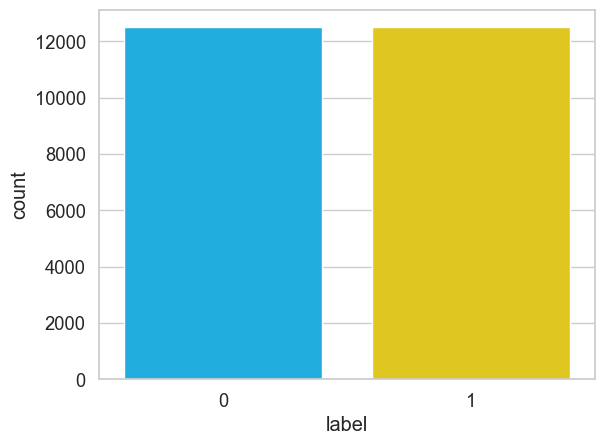

In [33]:
sns.countplot(data=train_data, x='label')

<Axes: xlabel='label', ylabel='ratings'>

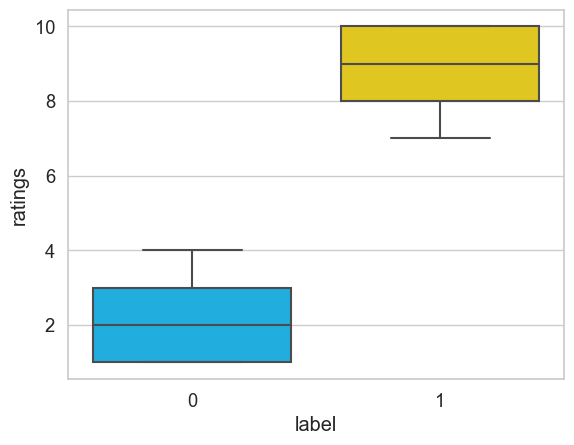

In [17]:
sns.boxplot(x='label', y='ratings', data=train_data)

In [31]:
train_data['text_length'] = train_data['text'].apply(lambda x: len(x)) # length of the text
train_data.head()

,text,label,ratings,clean_text,text_embedding,text_legnth,text_length
0,Bromwell High is a cartoon comedy. It ran at t...,1,9,bromwell high is a cartoon comedy it ran at th...,"[0.8779181241989136, 0.3795791566371918, -0.15...",806,806
1,Homelessness (or Houselessness as George Carli...,1,8,homelessness or houselessness a george carlin ...,"[0.7185903787612915, 0.16849711537361145, -0.4...",2366,2366
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,10,brilliant overacting by lesley ann warren best...,"[1.2952933311462402, -0.03307562321424484, -0....",841,841
3,This is easily the most underrated film inn th...,1,7,this is easily the most underrated film inn th...,"[0.7549100518226624, 1.3669123649597168, -0.31...",663,663
4,This is not the typical Mel Brooks film. It wa...,1,8,this is not the typical mel brook film it wa m...,"[0.5853791236877441, 0.4199213683605194, -1.60...",647,647


<Axes: xlabel='label', ylabel='text_length'>

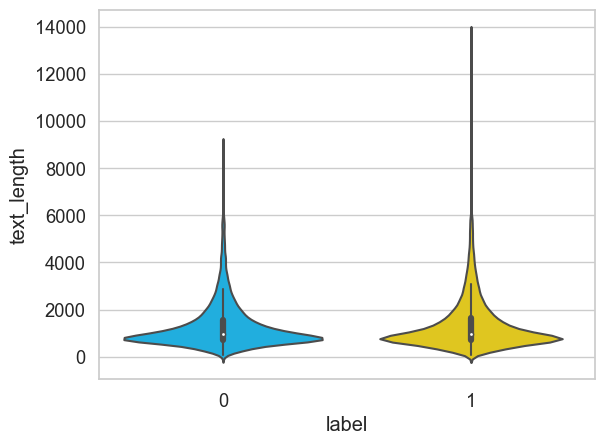

In [37]:
sns.violinplot(x='label', y='text_length', data=train_data)

c:\Users\hwndr\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hwndr\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hwndr\miniconda3\envs\ml\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'text Length')

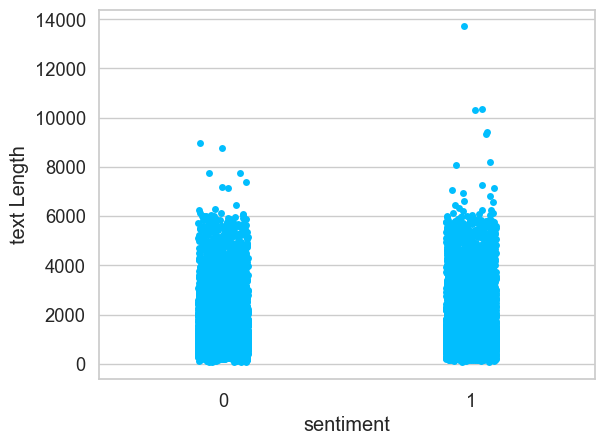

In [39]:
sns.stripplot(x='label', y='text_length', data=train_data, jitter=True)
plt.xlabel('sentiment')
plt.ylabel('text Length')

In [5]:
import ast
def convert_embedding(embedding_str):
    return np.array(ast.literal_eval(embedding_str))

In [65]:
train_data['text_embedding'] = train_data['text_embedding'].apply(convert_embedding)
test_data['text_embedding'] = test_data['text_embedding'].apply(convert_embedding)

In [66]:
train_data.head()

,text,label,ratings,clean_text,text_embedding
0,Bromwell High is a cartoon comedy. It ran at t...,1,9,bromwell high is a cartoon comedy it ran at th...,"[0.8779181241989136, 0.3795791566371918, -0.15..."
1,Homelessness (or Houselessness as George Carli...,1,8,homelessness or houselessness a george carlin ...,"[0.7185903787612915, 0.16849711537361145, -0.4..."
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,10,brilliant overacting by lesley ann warren best...,"[1.2952933311462402, -0.03307562321424484, -0...."
3,This is easily the most underrated film inn th...,1,7,this is easily the most underrated film inn th...,"[0.7549100518226624, 1.3669123649597168, -0.31..."
4,This is not the typical Mel Brooks film. It wa...,1,8,this is not the typical mel brook film it wa m...,"[0.5853791236877441, 0.4199213683605194, -1.60..."


In [73]:
train_embeddings = np.array(train_data['text_embedding'].tolist())
test_embeddings = np.array(test_data['text_embedding'].tolist())

In [74]:
train_pool = Pool(train_embeddings, train_data['label'])

In [75]:
clf = CatBoostClassifier(task_type='GPU', 
                         devices='0', 
                         loss_function='Logloss',
                         iterations=500,
                         learning_rate=0.1,
                         depth=6,
                         eval_metric='AUC',
                         verbose=100,
                         random_seed=42)

In [76]:
clf.fit(train_pool, eval_set=(test_embeddings, test_data['label']), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8837945	best: 0.8837945 (0)	total: 146ms	remaining: 1m 12s
100:	test: 0.9723405	best: 0.9723405 (100)	total: 9.65s	remaining: 38.1s
200:	test: 0.9743395	best: 0.9743395 (200)	total: 18.8s	remaining: 28s
300:	test: 0.9753341	best: 0.9753361 (295)	total: 27.9s	remaining: 18.4s
400:	test: 0.9757165	best: 0.9757187 (395)	total: 36.4s	remaining: 8.98s
499:	test: 0.9758016	best: 0.9758087 (475)	total: 45s	remaining: 0us
bestTest = 0.9758087397
bestIteration = 475
Shrink model to first 476 iterations.


In [77]:
y_pred = clf.predict(test_embeddings)

In [79]:
from sklearn.metrics import classification_report

print(classification_report(test_data['label'], y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     12500
           1       0.91      0.94      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

